# Using BERT for sentiment analysis

## **Bidirectional Representation for Transformers (BERT)**
BERT is a powerful technique for natural language processing that can improve how well computers comprehend human language. The foundation of BERT is the idea of exploiting bidirectional context to acquire complex and insightful word and phrase representations. By simultaneously examining both sides of a word's context, BERT can capture a word's whole meaning in its context, in contrast to earlier models that only considered the left or right context of a word. This enables BERT to deal with ambiguous and complex linguistic phenomena including polysemy, co-reference, and long-distance relationships.

IMPORT LIBRARIES

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=119e41bb192199ef12763465a4c3e0f04a0f97638305bd5cfb4f85102ad47aa9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

!pip install -q line
from lime.lime_text import LimeTextExplainer

import warnings
warnings.filterwarnings("ignore")

import os
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")

if not os.path.exists(nltk_data_path):
  os.makedirs(nltk_data_path)

  nltk.data.path.append(nltk_data_path)

  required_packages = ["stopwords", "wordnet", "omw-1.4"]

  for package in required_packages:
    try:
      nltk.data.find(f"corpora/{package}")
    except LookupError:
      print(f"Downloading NLTK package: {package}")
      nltk.download(package, download_dir = nltk_data_path)

  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Ensure Proper NLTK Data Download

In [3]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4") # necessary WordNet Lemmatizer
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


READ DATASET

In [4]:
df = pd.read_csv("/content/Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


EXPLORATORY DATA ANALYSIS

Dataset contains 14640 rows and 15 columns.

Missing values in each column:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


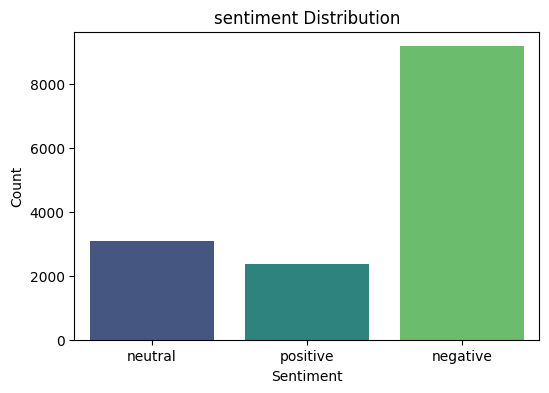

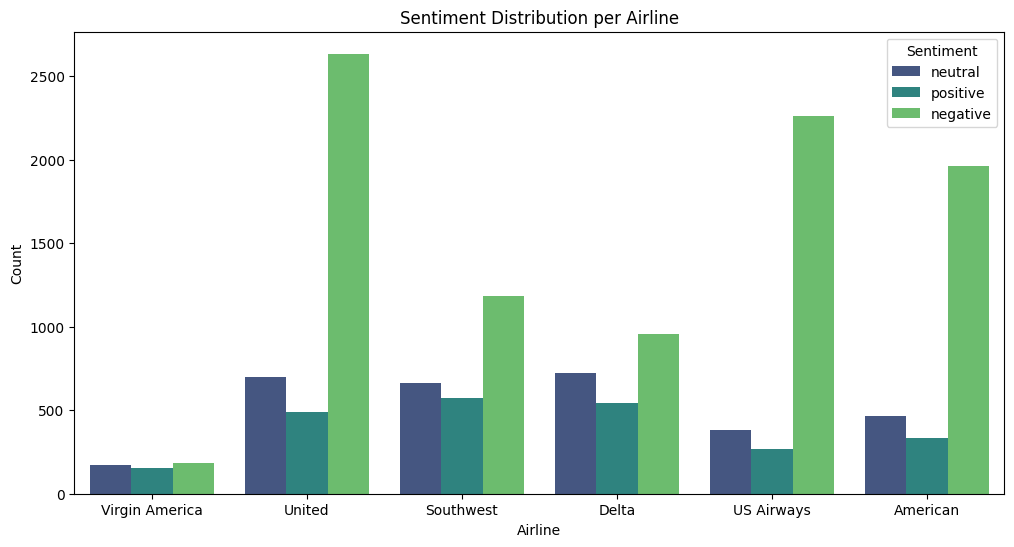

In [5]:
# Check the shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Distribution of Sentiments per airline
plt.figure(figsize=(6, 4))
sns.countplot(x="airline_sentiment", data=df, palette="viridis")
plt.title("sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Distribution of sentiments per airline
plt.figure(figsize=(12, 6))
sns.countplot(x="airline", hue="airline_sentiment", data=df, palette="viridis")
plt.title("Sentiment Distribution per Airline")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.show()

DATA PREPROCESSING

Preprocessing is crucial for improving the performance of NLP models. We'll clean the text data by removing URLs, mentions, special characters, stopwords, and perform lemmatization.

Note: When using BERT or other transformer-based models, minimal preprocessing is often preferred since these models are designed to handle raw text effectively. However, if you still choose to preprocess, ensure it doesn't remove essential information.

In [9]:
def preprocess_text(text):
  # check if text is a string
  if not isinstance(text, str):
    return ""

  # lowercase
  text = text.lower()

  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

  # Remove user @ references and "#" from hashtags
  text = re.sub(r"\@\w+|\#", "", text)

  # Remove special characters, numbers, and punctuations
  text = re.sub(r"\w", " ", text)
  text = re.sub(r"\d", " ", text)

  # Remove single characters
  text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

  #nRemove multiple spaces
  text = re.sub(r"\s+", " ", text)

# Apply preprocessing
df["clean_text"] = df["text"].apply(preprocess_text)

# Display clean text
df[["text", "clean_text"]].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,None
1,@VirginAmerica plus you've added commercials t...,None
2,@VirginAmerica I didn't today... Must mean I n...,None
3,@VirginAmerica it's really aggressive to blast...,None
4,@VirginAmerica and it's a really big bad thing...,None


Feature Extraction:

We'll convert the text data into numerical features using TF-IDF Vectorization.

In [38]:
# Use the column that actually has data
x = df["text"]
y = df["airline_sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Split the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Handle potential NaNs in the original text column
x_train_clean = x_train.fillna("").astype(str)
x_test_clean = x_test.fillna("").astype(str)

# Initialize and Fit
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

x_train_tfidf = tfidf.fit_transform(x_train_clean)
x_test_tfidf = tfidf.transform(x_test_clean)

print(f"Success! Vocabulary size: {len(tfidf.vocabulary_)}")

Success! Vocabulary size: 12912


Model Training with BERT:

We'll utilize Hugging Face's transformers library to fine-tune a pre-trained BERT model for sentiment classification. BERT (Bidirectional Encoder Representations from Transformers) has achieved state-of-the-art results in various NLP tasks due to its deep bidirectional understanding of language.

1. Encoding Labels

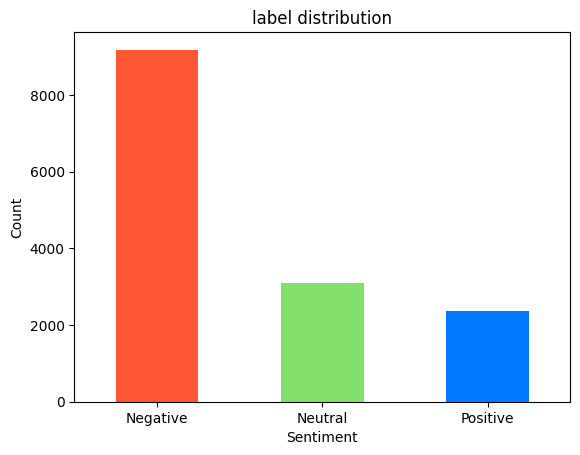

In [39]:
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}

df["label"] = df["airline_sentiment"].map(label_mapping)

# Display label distribution with custom colors
colors = ['#FF5733', '#85df6d', '#007BFF']

df["label"].value_counts().sort_index().plot(kind="bar", color=colors)

plt.title("label distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0,1,2], labels=["Negative", "Neutral", "Positive"], rotation = 0)
plt.show()

2. Splitting the Dataset

In [41]:
# Define features and labels
x = df["clean_text"]
y = df["label"]

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

print(f"Training set size: {x_train.shape[0]}")
print(f"Testing set size: {x_test.shape[0]}")

Training set size: 11712
Testing set size: 2928


3. Tokenization

In [51]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
def tokenize_function(texts):
  return tokenizer(texts.tolist(),
                   padding=True,
                   truncation=True,
                   max_length=128
                   )

  # tokenize training and testing data
# Use the cleaned variables that have no None/NaN values
train_encodings = tokenize_function(x_train_clean)
test_encodings = tokenize_function(x_test_clean)

4. Creating Dataset Objects

In [52]:
import torch
from torch.utils.data import Dataset

class TweetsDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    item["labels"] = torch.tensor(self.labels[idx])
    return item


# Create dataset objects
train_dataset = TweetsDataset(train_encodings, y_train.tolist())

test_dataset = TweetsDataset(test_encodings, y_test.tolist())

5. Fine-Tuning BERT

In [59]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Initialize the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # Negative, Neutral, Positive
    output_attentions=False,
    output_hidden_states=False
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy='epoch',
    report_to="none",  # <--- Add this line to disable wandb/tensorboard
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# Define a metric computation function
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


6. Training the Model

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss


Evaluating model

In [ ]:
import matplotlib.colors as mcolors

# Predictions
predictions, true_labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))

# Create a custom colormap
cmap = mcolors.ListedColormap(['#ffffff', '#85df6d', '#3cb371', '#006400'])  # White to light green to dark green

sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy * 100:.2f}%")